In [1]:
import pyemu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy as fp
from flopy.utils.reference import SpatialReference
import os
import sys

sys.path.append("../../modules")
# hand made functions
from Rouss import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [2]:
ws = "workspace"
m_n_i = "pest_2d_r"
m_n = "pest_2D_R"

case = "2D_test"

In [3]:
sim = fp.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package obs...
    loading package npf...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
  loading ims package pest_2d_r...


In [4]:
sr = SpatialReference(delr=m.dis.delr.array, delc=m.dis.delc.array, xll=m.dis.xorigin.array, yll=m.dis.yorigin.array)
sr

xul:664525; yul:6207475; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [5]:
# empty pst object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-06-29 22:43:42.800770 starting: opening PstFrom.log for logging
2020-06-29 22:43:42.800770 starting PstFrom process
2020-06-29 22:43:42.808795 starting: setting up dirs
2020-06-29 22:43:42.810821 starting: removing existing new_d 'template'
2020-06-29 22:43:42.838982 finished: removing existing new_d 'template' took: 0:00:00.028161
2020-06-29 22:43:42.838982 starting: copying original_d 'workspace' to new_d 'template'
2020-06-29 22:43:42.921457 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.082475
2020-06-29 22:43:42.929482 finished: setting up dirs took: 0:00:00.120687


In [6]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads2.csv"),index_col=0)

hds_df = pf.add_observations("heads2.csv",insfile="heads2.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

2020-06-29 22:43:42.959731 starting: adding observations from tabular output file
2020-06-29 22:43:42.961842 starting: reading list template\heads2.csv
2020-06-29 22:43:42.971910 finished: reading list template\heads2.csv took: 0:00:00.010068
2020-06-29 22:43:42.971910 starting: building insfile for tabular output file heads2.csv
2020-06-29 22:43:43.002146 finished: building insfile for tabular output file heads2.csv took: 0:00:00.030236
2020-06-29 22:43:43.002146 starting: adding observation from instruction file 'template\heads2.csv.ins'
2020-06-29 22:43:43.022296 finished: adding observation from instruction file 'template\heads2.csv.ins' took: 0:00:00.020150
2020-06-29 22:43:43.022296 finished: adding observations from tabular output file took: 0:00:00.062565


In [7]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:0, nnz_obs:122


spatial variogram


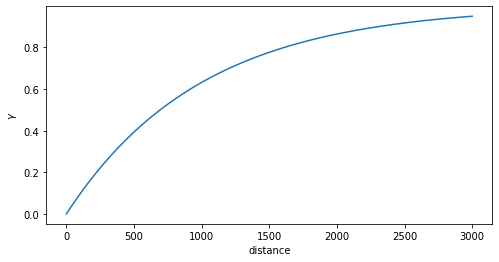

In [8]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=1000)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

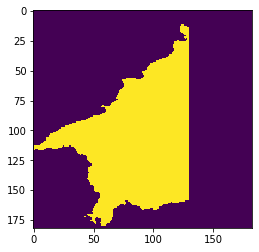

In [9]:
za = m.dis.idomain.array[0]
za[:,130:]=0
plt.imshow(za)

In [10]:
pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=14,zone_array=za,
                   par_name_base="kp",pargp="hp",
                   upper_bound=100,lower_bound=0.01,ult_ubound=1e-3,ult_lbound=1e-6,geostruct=grid_gs)

2020-06-29 22:43:44.260741 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-06-29 22:43:44.260741 starting: loading array template\k.txt
2020-06-29 22:43:44.341270 finished: loading array template\k.txt took: 0:00:00.080529
2020-06-29 22:43:44.341270 loaded array 'k.txt' of shape (182, 183)
2020-06-29 22:43:44.431876 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-06-29 22:43:44.431876 starting: setting up pilot point parameters
2020-06-29 22:43:44.431876 No spatial reference (containing cell spacing) passed.
2020-06-29 22:43:44.431876 OK - using spatial reference in parent object.
2020-06-29 22:43:44.854793 46 pilot point parameters created
2020-06-29 22:43:44.862844 pilot point 'pargp':kp_inst:0
2020-06-29 22:43:44.862844 finished: setting up pilot point parameters took: 0:00:00.430968
2020-06-29 22:43:44.874907 starting: calculating factors for pargp=kp_inst:0
2020-06-29 22:43:44.882951 saving krige variance file: